In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from scikitplot.metrics import plot_roc
from sklearn.model_selection import cross_val_score

# check xgboost version
from xgboost import XGBClassifier, XGBRegressor

import dill as pickle

## alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %pip install xgboost==1.5.0

In [3]:
#pd.set_option('max_columns', 200)
pd.options.display.max_columns = 200 

seed = 42
np.random.seed(seed)

***
### Funções

In [4]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [5]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [6]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [7]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(20, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 45)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [8]:
FILE = "/kaggle/input/datasetsnew/pca_tem_clientes_iphone.csv"

In [9]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [10]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
#     new_clients = new_clients.sample(frac = 0.005)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [11]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.age': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\
             .rename(columns={'a.peso_aparelho': 'peso_aparelho'})\
             .rename(columns={'a.update_software': 'update_software'})

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,imei,ranking,cpfidentifier,subscriberkey,customerkey,customersubtypedesc,subscriberstatuskey,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5565999265165,724066612678868,35349023,2021-12-18,NaN,10,0,0,APPLE,IPHONE 12 (A2403),353490236456470,1,2.631090e+05,604224760,119428092,Pessoa Física,A,Controle,NaN,MATO GROSSO,VIVO CONTROLE 11GB - ANUAL_,64.70,0,0,1,2021,38.0,0.0,0.0,2403,1
1,5565996041302,724066611593482,35679711,2020-11-17,NaN,23,1,0,APPLE,IPHONE SE (A2296),356797112105670,1,2.631090e+05,604224756,119428092,Pessoa Física,A,Controle,NaN,MATO GROSSO,VIVO CONTROLE 11GB - ANUAL_,64.70,0,1,0,2020,38.0,0.0,0.0,2296,1
2,5551998556400,724065007828219,35991435,2022-03-18,NaN,7,0,1,APPLE,IPHONE 11 (A2221),359914356228210,2,3.696081e+06,3554282,115295209,Pessoa Física,A,PostPaid,NaN,RIO GRANDE DO SUL,Titular Vivo Pós 20GB,30.00,0,1,0,2021,40.0,16.0,16.0,2221,1
3,5551997846198,724065490309921,35268265,2022-05-23,NaN,4,0,1,APPLE,IPHONE 11 (A2221),352682651761690,2,4.175050e+06,407197530,122143614,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_ANUAL_,52.88,0,1,0,2021,41.0,24.0,24.0,2221,1
4,5561996673683,724066704999331,35638710,2022-05-03,2022-05-04,0,0,1,APPLE,IPHONE 7 (A1778),356387108240910,2,4.267176e+06,56703864,148172738,Pessoa Física,A,Controle,NaN,GOIAS,VIVO CONTROLE 7GB_,56.79,0,1,0,2019,36.0,4.0,4.0,1778,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840754,5592991828835,724119704975902,35101064,2022-01-14,NaN,9,0,0,APPLE,IPHONE SE (A2296),351010642430250,1,9.994074e+10,617729505,142363430,Pessoa Física,A,Controle,NaN,AMAZONAS,VIVO CONTROLE 11GB - ANUAL,64.46,0,1,0,2020,40.0,0.0,0.0,2296,1
5840755,5551997161264,724065007590046,35489509,2022-05-09,NaN,5,0,1,APPLE,IPHONE 8 (A1863),354895090883020,2,9.995038e+10,208405860,124097954,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 4GB,37.31,0,1,0,2018,42.0,7.0,7.0,1863,1
5840756,5564999892388,724066709468154,35645310,2020-09-30,NaN,24,2,0,APPLE,IPHONE XR (A2105),356453109880890,1,9.997850e+10,416523308,145546494,Pessoa Física,A,PostPaid,NaN,GOIAS,TITULAR VIVO SELFIE BASICO 16GB,92.99,0,1,0,2019,40.0,0.0,0.0,2105,1
5840757,5564996127200,724066490126822,35723609,2021-08-07,NaN,14,1,0,APPLE,IPHONE XS (A2098),357236091796800,1,9.999792e+10,1270955,110068036,Pessoa Física,A,Controle,NaN,GOIAS,VIVO CONTROLE 11GB - ANUAL_,64.55,0,1,0,2018,38.0,0.0,0.0,2098,1


### Limpeza dos dados

In [12]:
# dados.groupby('aging_aparelho').count()
# print(dados.groupby('aging_aparelho')['aging_aparelho'].count().to_string())

In [13]:
dados = dados[dados['peso_aparelho'] != 'IPHONE4']
dados = dados[dados['peso_aparelho'] != 'IPHONE3G']
dados = dados[dados['peso_aparelho'] != 'IPHONE']
dados = dados[dados['peso_aparelho'] != 'IPHONE3GS']
dados = dados[dados['peso_aparelho'] != 'DIGIPHONE K6700I']
dados = dados[dados['peso_aparelho'] != 'GENIPHONE 9 MINI']
dados = dados[dados['offertechnology'] != 'VOIP']

In [14]:
dados = dados[dados['aging_aparelho'] >= 12]

In [15]:
dados['aging_aparelho'].unique()

array([ 23,  14,  15,  27,  39,  13,  19,  45,  24,  20,  49,  35,  44,
        22,  17,  30,  28,  48,  18,  34,  21,  53,  26,  37,  31,  12,
        36,  25,  47,  32,  62,  33,  16,  42,  40,  51,  80,  41,  50,
        29,  43,  63,  46,  58,  76,  61,  65,  38,  54,  55,  64,  56,
        57,  68,  67,  52,  66,  59,  60,  74,  75,  71,  91,  78,  77,
        69,  81,  92,  82,  79,  84,  72,  83,  70,  93,  89,  85,  73,
        86, 104, 115, 109,  87,  94, 110,  88, 105, 102, 114,  90,  95,
        97,  96, 100, 107,  98, 108, 106, 103, 101, 111,  99, 118, 116,
       113, 112, 121, 119, 120, 117])

In [16]:
dados = dados[dados['aging_aparelho'] <= 48]

In [17]:
dados['aging_aparelho'].unique()

array([23, 14, 15, 27, 39, 13, 19, 45, 24, 20, 35, 44, 22, 17, 30, 28, 48,
       18, 34, 21, 26, 37, 31, 12, 36, 25, 47, 32, 33, 16, 42, 40, 41, 29,
       43, 46, 38])

In [18]:
# dados_2018 = dados[dados['dt_ano_stts'] == 2018]
# dados_2018

In [19]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     2772529
cpfidentifier                    1
citydesc                   3149549
statedesc                      262
subscribermainofferdesc       6667
assignedchargeamount          6475
idade                            3
dtype: int64

columns_with_nan.shape (7,)



In [20]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade'])\
                    .reset_index(drop=True)
# dados_droped

In [21]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      2766029
citydesc    3142365
dtype: int64

columns_with_nan.shape (2,)



### Equilibrando classes

In [22]:
# dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.55, random_state=3)
# dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [23]:
# dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
# dados_droped

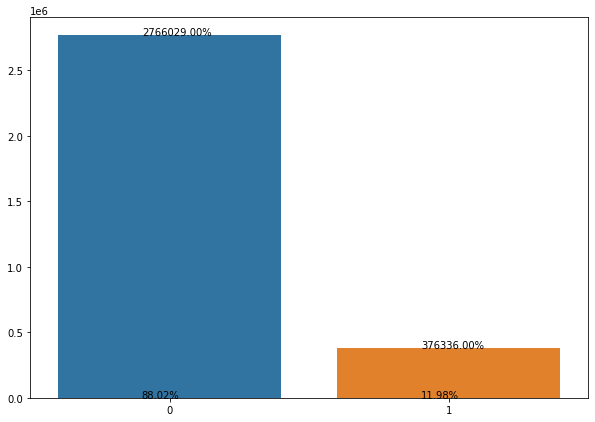

In [24]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

In [25]:
# dados_droped = dados_droped.tail(dados_droped.shape[0] -600000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int64')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
dados_droped['peso_aparelho'] = np.asarray(dados_droped['peso_aparelho'], dtype = 'int64')
dados_droped['update_software'] = np.asarray(dados_droped['update_software'], dtype = 'int64') 
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,imei,ranking,cpfidentifier,subscriberkey,customerkey,customersubtypedesc,subscriberstatuskey,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5565996041302,724066611593482,35679711,2020-11-17,NaN,23,1,0,APPLE,IPHONE SE (A2296),356797112105670,1,2.631090e+05,604224756,119428092,Pessoa Física,A,Controle,NaN,MATO GROSSO,VIVO CONTROLE 11GB - ANUAL_,64.70,0,1,0,2020,38,0.0,0.0,2296,1
1,5551998369343,724065404075131,35288311,2021-08-11,NaN,14,1,0,APPLE,IPHONE XR (A2105),352883118995600,1,4.331010e+06,605108620,120466946,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE II-10GB_,66.99,0,1,0,2019,40,0.0,0.0,2105,1
2,5551997756672,724065190063997,35682811,2021-08-12,NaN,14,1,0,APPLE,IPHONE XR (A2105),356828114108810,1,4.331010e+06,605108596,120466946,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE DIG-7GB_,52.88,0,1,0,2020,40,0.0,0.0,2105,1
3,5599991729193,724119812214064,35535408,2020-04-25,2022-04-14,23,1,1,APPLE,IPHONE 7 PLUS (A1784),355354086318370,1,8.510350e+06,204460406,113246661,Pessoa Física,A,Controle,NaN,MARANHAO,VIVO CONTROLE 7GB_,52.19,0,1,0,2016,39,23.0,23.0,1784,0
4,5571987770400,724117209902996,35566807,2021-07-08,NaN,15,1,0,APPLE,IPHONE 5S (A1457),355668076416530,1,1.532650e+07,418641174,149250414,Pessoa Física,A,Controle,NaN,BAHIA,VIVO CONTROLE 9GB I,60.30,0,1,0,2015,100,0.0,0.0,1457,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142360,5532999467468,724234290938555,35385532,2021-01-30,NaN,20,1,0,APPLE,IPHONE 11 (A2221),353855322713880,1,9.987006e+10,200552284,101432070,Pessoa Física,A,Controle,NaN,MINAS GERAIS,VIVOCONTROLEDIGITAL-9GB ILIM_,95.99,0,1,0,2020,46,0.0,0.0,2221,1
3142361,5531999670053,724234301913150,35308110,2020-02-08,NaN,32,2,0,APPLE,IPHONE XR (A2105),353081101005950,1,9.987616e+10,605521237,122696216,Pessoa Física,A,Controle,NaN,MINAS GERAIS,VIVO CONTROLE 11GB - ANUAL_,66.34,0,1,0,2018,46,0.0,6.0,2105,1
3142362,5564999892388,724066709468154,35645310,2020-09-30,NaN,24,2,0,APPLE,IPHONE XR (A2105),356453109880890,1,9.997850e+10,416523308,145546494,Pessoa Física,A,PostPaid,NaN,GOIAS,TITULAR VIVO SELFIE BASICO 16GB,92.99,0,1,0,2019,40,0.0,0.0,2105,1
3142363,5564996127200,724066490126822,35723609,2021-08-07,NaN,14,1,0,APPLE,IPHONE XS (A2098),357236091796800,1,9.999792e+10,1270955,110068036,Pessoa Física,A,Controle,NaN,GOIAS,VIVO CONTROLE 11GB - ANUAL_,64.55,0,1,0,2018,38,0.0,0.0,2098,1


In [26]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142365 entries, 0 to 3142364
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   msisdn                   int64  
 1   imsi                     object 
 2   tac                      int64  
 3   dt_inicio                object 
 4   dt_fim                   object 
 5   aging_aparelho           int64  
 6   cat_aparelho             int64  
 7   trocou_aparelho          int64  
 8   fabricante               object 
 9   modelo                   object 
 10  imei                     object 
 11  ranking                  int64  
 12  cpfidentifier            float64
 13  subscriberkey            int64  
 14  customerkey              int64  
 15  customersubtypedesc      object 
 16  subscriberstatuskey      object 
 17  offertechnology          object 
 18  citydesc                 float64
 19  statedesc                object 
 20  subscribermainofferdesc  object 
 21  assigned

***
### Correlação

In [27]:
corr_trocou_aparelho = dados_droped[['fabricante', 'ranking', 'avg_msisdn', 'avg_cpf',
                                     'assignedchargeamount', 'peso_aparelho', 'update_software', 'aging_aparelho', 'trocou_aparelho']]

<AxesSubplot:>

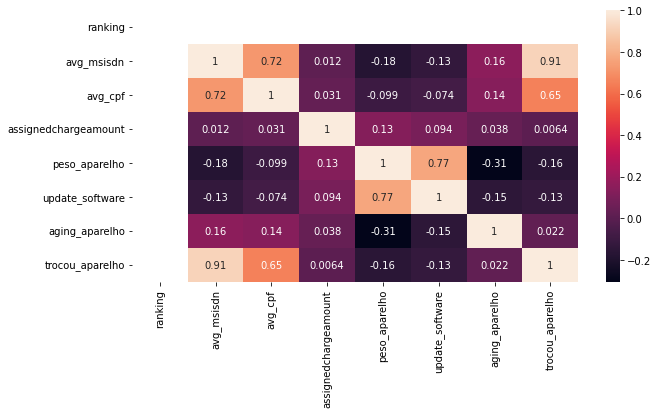

In [28]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

***
## Exploração dos dados

### seleção de features

In [29]:
# dados_droped['avg_msisdn'].unique()

In [30]:
# define features
X_ta = dados_droped[['avg_cpf', 'avg_msisdn']]

X_ta

,avg_cpf,avg_msisdn
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,23.0,23.0
4,0.0,0.0
...,...,...
3142360,0.0,0.0
3142361,6.0,0.0
3142362,0.0,0.0
3142363,0.0,0.0


In [31]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142365 entries, 0 to 3142364
Data columns (total 2 columns):
 #   Column      Dtype  
---  ------      -----  
 0   avg_cpf     float64
 1   avg_msisdn  float64
dtypes: float64(2)
memory usage: 47.9 MB


#### Variaveis Categoricas

In [32]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  0
[]


#### Variaveis Numéricas

In [33]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  2
['avg_cpf', 'avg_msisdn']


***
***
***
## Definição do Target trocou_aparelho

In [34]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 2766029, 1: 376336})

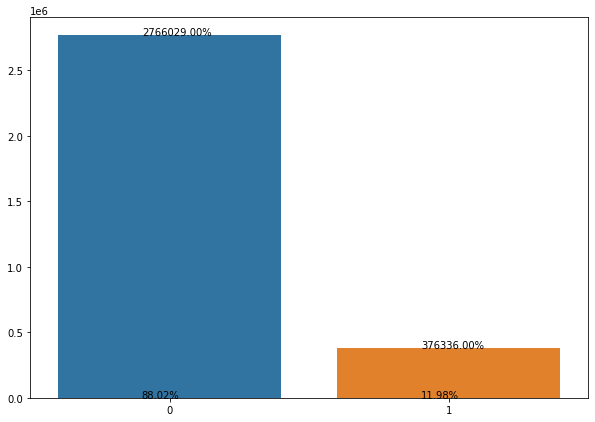

In [35]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

***
## Modelagem trocou_aparelho

In [36]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer_ta = Pipeline([
                                     ('scaler', StandardScaler())
                                    ])

# Pré-processamento para Dados Categóricos
categorical_transformer_ta = Pipeline([
                                       ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                      ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor_ta = ColumnTransformer(transformers=[
                                                  ('num', numerical_transformer_ta, numerical_cols_ta),
                                                  ('cat', categorical_transformer_ta, object_cols_ta)
                                                 ], n_jobs=-1)

pipeline_ta = Pipeline(steps=[
                              ('preprocessor', preprocessor_ta),
                              ('smote', SMOTE(random_state=42, n_jobs=-1)),
                              ('model', XGBClassifier(random_state=2048, n_jobs=-1))
                             ])

# Preprocessing of training data, fit model 
pipeline_ta.fit(X_train_ta, y_train_ta)

# Predictions
# preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds_ta = pipeline_ta.predict(X_val_ta)

[16:45:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Save Model

In [37]:
# Use pickle to save model for next usage.
filename = 'model_trocou_aparelho_apple.pk'
with open('./'+filename, 'wb') as file:
    pickle.dump(pipeline_ta, file) 

In [38]:
train_yhat_ta = pipeline_ta.predict(X_train_ta)
train_acc_ta = accuracy_score(y_train_ta, train_yhat_ta)
print('Training Acuracy:', train_acc_ta)
val_acc_ta = accuracy_score(y_val_ta, preds_ta)
print('Validation Acuracy:', val_acc_ta)

Training Acuracy: 1.0
Validation Acuracy: 0.9999993635369018


In [39]:
c_train_ta = Counter(y_train_ta)
c_train_ta

Counter({0: 1383155, 1: 188027})

In [40]:
c_val_ta = Counter(y_val_ta)
c_val_ta


Counter({1: 188309, 0: 1382874})

In [41]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({1: 188308, 0: 1382875})

***
## Métricas

AUC: 1.000


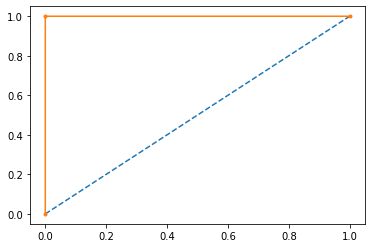

In [42]:
aucur(y_val_ta, preds_ta)

In [43]:
# # Multiply by -1 since sklearn calculates *negative* MAE
# scores = -1 * cross_val_score(pipeline_ta, X_ta, y_trocou_aparelho,
#                               cv=5, n_jobs=-1, verbose=2,
#                               scoring='f1')

# print("MAE scores:\n", scores)

In [44]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1382874
           1       1.00      1.00      1.00    188309

    accuracy                           1.00   1571183
   macro avg       1.00      1.00      1.00   1571183
weighted avg       1.00      1.00      1.00   1571183



In [45]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,1382874,0
1,1,188308


Confusion matrix, without normalization
[[1382874       0]
 [      1  188308]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [5.31042064e-06 9.99994690e-01]]


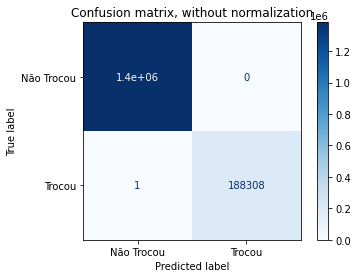

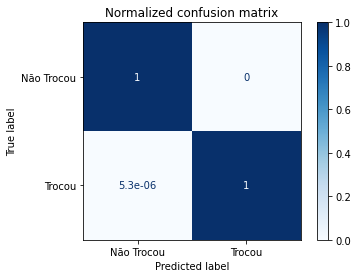

<Figure size 1296x1296 with 0 Axes>

In [46]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_val_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
***
***
### Testes com outros dados

In [47]:
FILE_teste = "/kaggle/input/datasetsnew/pca_tem_clientes_iphone_aging.csv"

In [48]:
client_chunks_teste = []
dados_teste2 = pd.read_csv(FILE_teste, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [49]:
for chunk2 in dados_teste2:

    new_clients2 = pd.DataFrame(chunk2)

    # filter data chunk with frac percentage
#     new_clients2 = new_clients2.sample(frac = 0.7)
    new_clients2 = new_clients2.drop_duplicates()

    # saves to list
    client_chunks_teste.append(new_clients2)

dados_val = pd.concat(client_chunks_teste).reset_index(drop = True)

In [50]:
dados_val = dados_val.rename(columns={'a.msisdn': 'msisdn'})\
                     .rename(columns={'a.imsi': 'imsi'})\
                     .rename(columns={'a.tac': 'tac'})\
                     .rename(columns={'a.dt_inicio': 'dt_inicio'})\
                     .rename(columns={'a.dt_fim': 'dt_fim'})\
                     .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
                     .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
                     .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
                     .rename(columns={'a.fabricante': 'fabricante'})\
                     .rename(columns={'a.modelo': 'modelo'})\
                     .rename(columns={'a.imei': 'imei'})\
                     .rename(columns={'a.ranking': 'ranking'})\
                     .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
                     .rename(columns={'a.subscriberkey': 'subscriberkey'})\
                     .rename(columns={'a.customerkey': 'customerkey'})\
                     .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
                     .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
                     .rename(columns={'a.offertechnology': 'offertechnology'})\
                     .rename(columns={'a.citydesc': 'citydesc'})\
                     .rename(columns={'a.statedesc': 'statedesc'})\
                     .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
                     .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
                     .rename(columns={'a.fl_3g': 'fl_3g'})\
                     .rename(columns={'a.fl_4g': 'fl_4g'})\
                     .rename(columns={'a.fl_5g': 'fl_5g'})\
                     .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
                     .rename(columns={'a.age': 'idade'})\
                     .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
                     .rename(columns={'a.avg_cpf': 'avg_cpf'})\
                     .rename(columns={'a.peso_aparelho': 'peso_aparelho'})\
                     .rename(columns={'a.update_software': 'update_software'})

dados_val

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,imei,ranking,cpfidentifier,subscriberkey,customerkey,customersubtypedesc,subscriberstatuskey,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5551998369343,724065404075131,35288311,2021-08-11,NaN,14,1,0,APPLE,IPHONE XR (A2105),352883118995600,1,4331010,605108620,120466946,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE II-10GB_,66.99,0,1,0,2019,40,0.0,0.0,2105,1
1,5551997756672,724065190063997,35682811,2021-08-12,NaN,14,1,0,APPLE,IPHONE XR (A2105),356828114108810,1,4331010,605108596,120466946,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE DIG-7GB_,52.88,0,1,0,2020,40,0.0,0.0,2105,1
2,5571987770400,724117209902996,35566807,2021-07-08,NaN,15,1,0,APPLE,IPHONE 5S (A1457),355668076416530,1,15326500,418641174,149250414,Pessoa Física,A,Controle,NaN,BAHIA,VIVO CONTROLE 9GB I,60.30,0,1,0,2015,100,0.0,0.0,1457,0
3,5511975910666,724102006026303,35898949,2021-09-15,NaN,13,1,0,APPLE,IPHONE 11 (A2221),358989493307580,1,26313855,206026952,118766072,Pessoa Física,A,PostPaid,NaN,SAO PAULO,TITULAR VIVO_POS 20GB,119.99,0,1,0,2021,64,0.0,0.0,2221,1
4,5511984264606,724101811694360,35444089,2021-09-05,NaN,13,1,0,APPLE,IPHONE 12 PRO MAX (A2342),354440899340070,1,32177607,406002953,118281156,Pessoa Física,A,Controle,NaN,SAO PAULO,VIVO CONTROLE 5GB IV,36.99,0,0,1,2021,47,0.0,0.0,2342,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112293,5531999044425,724233607546707,35382408,2020-12-12,2022-03-08,14,1,1,APPLE,IPHONE 7 (A1660),353824081727270,1,99732882620,207942329,123061528,Pessoa Física,A,Controle,NaN,MINAS GERAIS,VIVO CONTROLE 10GB PLN I - ANUAL,71.99,0,1,0,2016,49,14.0,14.0,1660,0
1112294,5553999551834,724065502986331,35504456,2021-10-08,NaN,12,1,0,APPLE,IPHONE 12 (A2172),355044569391910,1,99741229020,206189527,117791909,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_ANUAL_,52.88,0,0,1,2020,43,0.0,18.0,2172,1
1112295,5511957805212,724101890720577,35608409,2021-08-13,NaN,14,1,0,APPLE,IPHONE 8 (A1905),356084095226030,1,99750716868,223981,100242833,Pessoa Física,A,PostPaid,NaN,SAO PAULO,TITULAR VIVO_POS 20GB,119.99,0,1,0,2018,69,0.0,0.0,1905,1
1112296,5564996127200,724066490126822,35723609,2021-08-07,NaN,14,1,0,APPLE,IPHONE XS (A2098),357236091796800,1,99997924134,1270955,110068036,Pessoa Física,A,Controle,NaN,GOIAS,VIVO CONTROLE 11GB - ANUAL_,64.55,0,1,0,2018,38,0.0,0.0,2098,1


In [51]:
dados_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112298 entries, 0 to 1112297
Data columns (total 31 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   msisdn                   1112298 non-null  int64  
 1   imsi                     1112298 non-null  object 
 2   tac                      1112298 non-null  int64  
 3   dt_inicio                1112298 non-null  object 
 4   dt_fim                   126486 non-null   object 
 5   aging_aparelho           1112298 non-null  int64  
 6   cat_aparelho             1112298 non-null  int64  
 7   trocou_aparelho          1112298 non-null  int64  
 8   fabricante               1112298 non-null  object 
 9   modelo                   1112298 non-null  object 
 10  imei                     1112298 non-null  object 
 11  ranking                  1112298 non-null  int64  
 12  cpfidentifier            1112298 non-null  int64  
 13  subscriberkey            1112298 non-null 

In [52]:
dados_val = dados_val[dados_val['peso_aparelho'] != 'IPHONE4']
dados_val = dados_val[dados_val['peso_aparelho'] != 'IPHONE3G']
dados_val = dados_val[dados_val['peso_aparelho'] != 'IPHONE']
dados_val = dados_val[dados_val['peso_aparelho'] != 'IPHONE3GS' ]
dados_val = dados_val[dados_val['peso_aparelho'] != 'DIGIPHONE K6700I' ]
dados_val = dados_val[dados_val['peso_aparelho'] != 'GENIPHONE 9 MINI' ]
dados_val = dados_val[dados_val['offertechnology'] != 'VOIP']

In [53]:
dados_outros_anos = dados_val[dados_val['dt_ano_stts'] != 2018]
dados_outros_anos['dt_ano_stts'].unique()

# dados_outros_anos = dados[dados['dt_ano_stts'] != 2018]
# dados_outros_anos['dt_ano_stts'].unique()

array([2019, 2020, 2015, 2021, 2016, 2017, 2013, 2014, 2012, 2009, 2011,
       2010])

In [54]:
# just_check_nan(dados_outros_anos)
just_check_nan(dados_outros_anos)

Dados com NaN:
dt_fim                     825229
citydesc                   926356
statedesc                      95
subscribermainofferdesc      2330
assignedchargeamount         2269
dtype: int64

columns_with_nan.shape (5,)



In [55]:
dados_val = dados_outros_anos.dropna(subset=['imsi',
                                             'statedesc', 
                                             'subscribermainofferdesc', 
                                             'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade'])\
                             .reset_index(drop=True)
# dados_droped

In [56]:
just_check_nan(dados_val)

Dados com NaN:
dt_fim      822909
citydesc    923851
dtype: int64

columns_with_nan.shape (2,)



In [57]:
# dados_val = dados_val.tail(dados_val.shape[0] -1000000).reset_index(drop=True)
dados_val['dt_ano_stts'] = dados_val['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_val['idade'] = np.asarray(dados_val['idade'], dtype = 'int64')
dados_val['fl_3g'] = np.asarray(dados_val['fl_3g'], dtype = 'int8')
dados_val['fl_4g'] = np.asarray(dados_val['fl_4g'], dtype = 'int8')
dados_val['fl_5g'] = np.asarray(dados_val['fl_5g'], dtype = 'int8')
dados_val['peso_aparelho'] = np.asarray(dados_val['peso_aparelho'], dtype = 'int64')
dados_val['update_software'] = np.asarray(dados_val['update_software'], dtype = 'int64') 
dados_val

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,imei,ranking,cpfidentifier,subscriberkey,customerkey,customersubtypedesc,subscriberstatuskey,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5551998369343,724065404075131,35288311,2021-08-11,NaN,14,1,0,APPLE,IPHONE XR (A2105),352883118995600,1,4331010,605108620,120466946,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE II-10GB_,66.99,0,1,0,2019,40,0.0,0.0,2105,1
1,5551997756672,724065190063997,35682811,2021-08-12,NaN,14,1,0,APPLE,IPHONE XR (A2105),356828114108810,1,4331010,605108596,120466946,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE DIG-7GB_,52.88,0,1,0,2020,40,0.0,0.0,2105,1
2,5571987770400,724117209902996,35566807,2021-07-08,NaN,15,1,0,APPLE,IPHONE 5S (A1457),355668076416530,1,15326500,418641174,149250414,Pessoa Física,A,Controle,NaN,BAHIA,VIVO CONTROLE 9GB I,60.30,0,1,0,2015,100,0.0,0.0,1457,0
3,5511975910666,724102006026303,35898949,2021-09-15,NaN,13,1,0,APPLE,IPHONE 11 (A2221),358989493307580,1,26313855,206026952,118766072,Pessoa Física,A,PostPaid,NaN,SAO PAULO,TITULAR VIVO_POS 20GB,119.99,0,1,0,2021,64,0.0,0.0,2221,1
4,5511984264606,724101811694360,35444089,2021-09-05,NaN,13,1,0,APPLE,IPHONE 12 PRO MAX (A2342),354440899340070,1,32177607,406002953,118281156,Pessoa Física,A,Controle,NaN,SAO PAULO,VIVO CONTROLE 5GB IV,36.99,0,0,1,2021,47,0.0,0.0,2342,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923846,5522999721094,724112104006805,35288711,2021-05-09,NaN,17,1,0,APPLE,IPHONE XR (A2105),352887113200730,1,99702169704,5011008,122104691,Pessoa Física,A,Controle,NaN,RIO DE JANEIRO,VIVO CONTROLE 11GB - ANUAL_,65.40,0,1,0,2019,65,0.0,0.0,2105,1
923847,5551996922764,724065202991814,35856307,2020-09-14,2022-02-12,16,1,1,APPLE,IPHONE 6S (A1688),358563078893190,1,99723344068,201012150,101795410,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 6GB III,50.99,0,1,0,2016,40,16.0,16.0,1688,0
923848,5531999044425,724233607546707,35382408,2020-12-12,2022-03-08,14,1,1,APPLE,IPHONE 7 (A1660),353824081727270,1,99732882620,207942329,123061528,Pessoa Física,A,Controle,NaN,MINAS GERAIS,VIVO CONTROLE 10GB PLN I - ANUAL,71.99,0,1,0,2016,49,14.0,14.0,1660,0
923849,5553999551834,724065502986331,35504456,2021-10-08,NaN,12,1,0,APPLE,IPHONE 12 (A2172),355044569391910,1,99741229020,206189527,117791909,Pessoa Física,A,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_ANUAL_,52.88,0,0,1,2020,43,0.0,18.0,2172,1


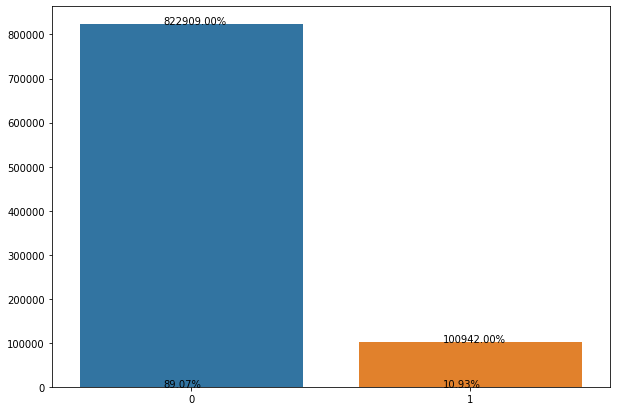

In [58]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_val, 'trocou_aparelho')

In [59]:
X_teste = dados_val.drop('trocou_aparelho', axis=1)

y_teste = dados_val['trocou_aparelho']

In [60]:
preds_val = pipeline_ta.predict(X_teste)
preds_val

array([0, 0, 0, ..., 1, 0, 0])

AUC: 1.000


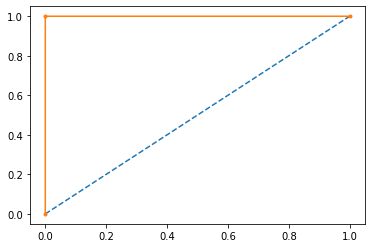

In [61]:
aucur(y_teste, preds_val)

In [62]:
print(classification_report(y_teste, preds_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    822909
           1       1.00      1.00      1.00    100942

    accuracy                           1.00    923851
   macro avg       1.00      1.00      1.00    923851
weighted avg       1.00      1.00      1.00    923851



Confusion matrix, without normalization
[[822909      0]
 [     1 100941]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [9.90667908e-06 9.99990093e-01]]


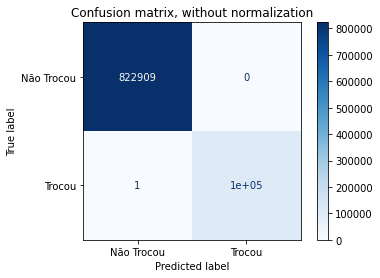

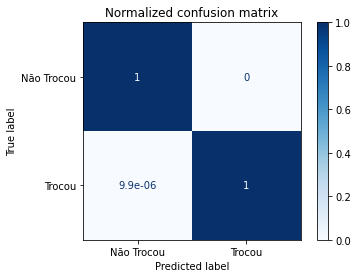

<Figure size 1296x1296 with 0 Axes>

In [63]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_teste,
        y_teste,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

In [64]:
train_yhat_ta = pipeline_ta.predict(X_train_ta)
train_acc_ta = accuracy_score(y_train_ta, train_yhat_ta)
print('Training Acuracy:', train_acc_ta)
val_acc_ta = accuracy_score(y_val_ta, preds_ta)
print('Validation Acuracy:', val_acc_ta)
teste_acc_ta = accuracy_score(y_teste, preds_val)
print('Test Acuracy:', teste_acc_ta)

Training Acuracy: 1.0
Validation Acuracy: 0.9999993635369018
Test Acuracy: 0.9999989175743708


***
***
***
## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

Base Original

In [65]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<Figure size 576x432 with 0 Axes>

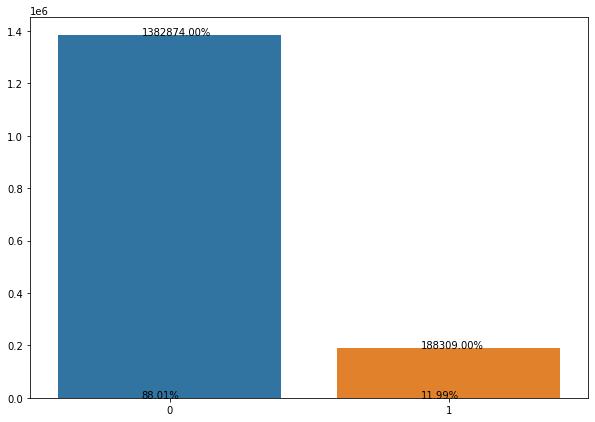

In [66]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho')

Base Prevista

In [67]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<Figure size 576x432 with 0 Axes>

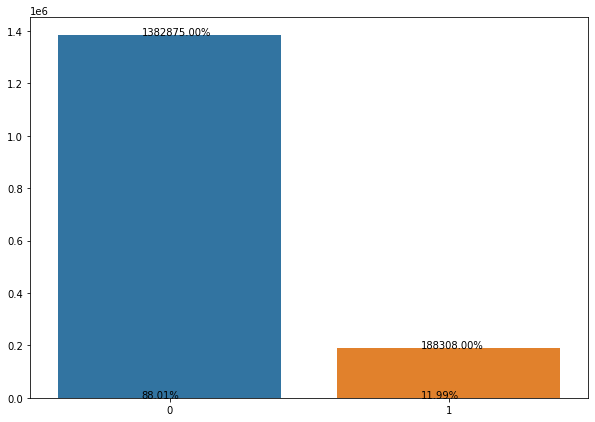

In [68]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto')

In [69]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [70]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [71]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
X_val_ta['fabricante'] = dados_droped['fabricante']
X_val_ta['modelo'] = dados_droped['modelo']
X_val_ta['ranking'] = dados_droped['ranking']
X_val_ta['aging_aparelho'] = dados_droped['aging_aparelho']
X_val_ta['subscribermainofferdesc'] = dados_droped['subscribermainofferdesc']
X_val_ta['assignedchargeamount'] = dados_droped['assignedchargeamount']
X_val_ta['offertechnology'] = dados_droped['offertechnology']
X_val_ta['statedesc'] = dados_droped['statedesc']
X_val_ta['fl_3g'] = dados_droped['fl_3g']
X_val_ta['fl_4g'] = dados_droped['fl_4g']
X_val_ta['fl_5g'] = dados_droped['fl_5g']
X_val_ta['idade'] = dados_droped['idade']
X_val_ta['avg_msisdn'] = dados_droped['avg_msisdn']
X_val_ta['avg_cpf'] = dados_droped['avg_cpf']
X_val_ta['peso_aparelho'] = dados_droped['peso_aparelho']
X_val_ta['update_software'] = dados_droped['update_software']

X_val_ta

,avg_cpf,avg_msisdn,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,fabricante,modelo,ranking,aging_aparelho,subscribermainofferdesc,assignedchargeamount,offertechnology,statedesc,fl_3g,fl_4g,fl_5g,idade,peso_aparelho,update_software
2082068,12.0,12.0,1,1,3.872063e+09,2021-04-02,2022-04-27,APPLE,IPHONE SE (A2275),1,12,VIVO CONTROLE 5GB IV,41.99,Controle,RIO GRANDE DO SUL,0,1,0,21,2275,1
1759089,0.0,0.0,0,0,5.444582e+09,2020-10-13,NaN,APPLE,IPHONE 11 (A2221),1,24,LINHA ADICIONAL VIVO FAMILIA 100GB,62.99,PostPaid,CEARA,0,1,0,30,2221,1
799606,0.0,0.0,0,0,4.263993e+09,2021-05-17,NaN,APPLE,IPHONE 8 PLUS (A1864),1,17,VIVO CONTROLE 9GB I,59.25,Controle,GOIAS,0,1,0,22,1864,1
2405796,0.0,0.0,0,0,2.453626e+09,2021-08-19,NaN,APPLE,IPHONE 6S (A1688),1,14,VIVO CONTROLE 6GB III,45.99,Controle,PARANA,0,1,0,43,1688,0
1852902,0.0,0.0,0,0,4.266354e+10,2021-10-06,NaN,APPLE,IPHONE 11 (A2221),1,12,TITULAR VIVO POS 30GB,147.63,PostPaid,SAO PAULO,0,1,0,28,2221,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472289,0.0,0.0,0,0,8.332961e+10,2021-08-05,NaN,APPLE,IPHONE 12 PRO MAX (A2411),1,14,TITULAR VIVO SELFIE BASICO 16GB,92.99,PostPaid,AMAZONAS,0,0,1,38,2411,1
200907,0.0,0.0,0,0,2.885576e+09,2020-01-21,NaN,APPLE,IPHONE 11 (A2221),1,32,TITULAR VIVO PÓS MIG_20GB,109.99,PostPaid,MINAS GERAIS,0,1,0,45,2221,1
1529882,0.0,0.0,0,0,4.780636e+10,2021-01-08,NaN,APPLE,IPHONE 11 (A2221),1,21,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,0.00,PostPaid,RIO GRANDE DO SUL,0,1,0,56,2221,1
2171318,35.0,35.0,1,1,7.786287e+09,2019-03-06,2022-02-25,APPLE,IPHONE 7 (A1660),1,35,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,109.99,PostPaid,SAO PAULO,0,1,0,55,1660,0


***
***
***
## Separando as bases para outro modelo

In [72]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,avg_cpf,avg_msisdn,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,fabricante,modelo,ranking,aging_aparelho,subscribermainofferdesc,assignedchargeamount,offertechnology,statedesc,fl_3g,fl_4g,fl_5g,idade,peso_aparelho,update_software
0,12.0,12.0,1,1,3.872063e+09,2021-04-02,2022-04-27,APPLE,IPHONE SE (A2275),1,12,VIVO CONTROLE 5GB IV,41.99,Controle,RIO GRANDE DO SUL,0,1,0,21,2275,1
1,46.0,46.0,1,1,2.774261e+09,2018-05-16,2022-03-27,APPLE,IPHONE X (A1865),1,46,TITULAR VIVO FAMILIA 60GB,247.67,PostPaid,RIO DE JANEIRO,0,1,0,51,1865,1
2,43.0,43.0,1,1,1.017975e+10,2018-08-30,2022-04-20,APPLE,IPHONE 7 (A1778),1,43,VIVO CONTROLE 7GB_,52.88,Controle,ESPIRITO SANTO,0,1,0,27,1778,0
3,24.0,24.0,1,1,2.526419e+10,2020-04-15,2022-05-07,APPLE,IPHONE 11 PRO (A2215),1,24,Linha Adicional Vivo Pós Família 300GB,0.00,PostPaid,MINAS GERAIS,0,1,0,52,2215,1
4,23.0,23.0,1,1,2.902122e+10,2020-03-14,2022-02-20,APPLE,IPHONE 8 (A1905),1,23,TITULAR VIVO FAMILIA 60GB,235.13,PostPaid,SAO PAULO,0,1,0,47,1905,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188303,14.5,14.5,1,1,1.035502e+10,2019-12-16,2022-04-22,APPLE,IPHONE 8 (A1905),1,28,Linha Adicional Vivo Pós Família 300GB,0.00,PostPaid,SAO PAULO,0,1,0,53,1905,1
188304,10.5,10.5,1,1,1.312426e+10,2020-07-13,2022-03-01,APPLE,IPHONE 11 PRO MAX (A2218),1,19,Titular Vivo Pós Família 120GB,138.99,PostPaid,SAO PAULO,0,1,0,52,2218,1
188305,19.0,19.0,1,1,2.075664e+09,2020-07-30,2022-03-17,APPLE,IPHONE 7 PLUS (A1661),1,19,VIVO CONTROLE 5GB II,44.99,Controle,BAHIA,0,1,0,38,1661,0
188306,18.0,18.0,1,1,3.204663e+09,2020-12-03,2022-06-20,APPLE,IPHONE 7 (A1778),1,18,VIVO CONTROLE 6GB III,45.99,Controle,GOIAS,0,1,0,27,1778,0


In [127]:
base_to_pred_month

,avg_cpf,avg_msisdn,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,fabricante,modelo,ranking,aging_aparelho,subscribermainofferdesc,assignedchargeamount,offertechnology,statedesc,fl_3g,fl_4g,fl_5g,idade,peso_aparelho,update_software
0,12.0,12.0,1,1,3.872063e+09,2021-04-02,2022-04-27,APPLE,IPHONE SE (A2275),1,12,VIVO CONTROLE 5GB IV,41.99,Controle,RIO GRANDE DO SUL,0,1,0,21,2275,1
1,46.0,46.0,1,1,2.774261e+09,2018-05-16,2022-03-27,APPLE,IPHONE X (A1865),1,46,TITULAR VIVO FAMILIA 60GB,247.67,PostPaid,RIO DE JANEIRO,0,1,0,51,1865,1
2,43.0,43.0,1,1,1.017975e+10,2018-08-30,2022-04-20,APPLE,IPHONE 7 (A1778),1,43,VIVO CONTROLE 7GB_,52.88,Controle,ESPIRITO SANTO,0,1,0,27,1778,0
3,24.0,24.0,1,1,2.526419e+10,2020-04-15,2022-05-07,APPLE,IPHONE 11 PRO (A2215),1,24,Linha Adicional Vivo Pós Família 300GB,0.00,PostPaid,MINAS GERAIS,0,1,0,52,2215,1
4,23.0,23.0,1,1,2.902122e+10,2020-03-14,2022-02-20,APPLE,IPHONE 8 (A1905),1,23,TITULAR VIVO FAMILIA 60GB,235.13,PostPaid,SAO PAULO,0,1,0,47,1905,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188303,14.5,14.5,1,1,1.035502e+10,2019-12-16,2022-04-22,APPLE,IPHONE 8 (A1905),1,28,Linha Adicional Vivo Pós Família 300GB,0.00,PostPaid,SAO PAULO,0,1,0,53,1905,1
188304,10.5,10.5,1,1,1.312426e+10,2020-07-13,2022-03-01,APPLE,IPHONE 11 PRO MAX (A2218),1,19,Titular Vivo Pós Família 120GB,138.99,PostPaid,SAO PAULO,0,1,0,52,2218,1
188305,19.0,19.0,1,1,2.075664e+09,2020-07-30,2022-03-17,APPLE,IPHONE 7 PLUS (A1661),1,19,VIVO CONTROLE 5GB II,44.99,Controle,BAHIA,0,1,0,38,1661,0
188306,18.0,18.0,1,1,3.204663e+09,2020-12-03,2022-06-20,APPLE,IPHONE 7 (A1778),1,18,VIVO CONTROLE 6GB III,45.99,Controle,GOIAS,0,1,0,27,1778,0


***
### Correlação

In [73]:
corr_aging_aparelho = base_to_pred_month[['fabricante', 'ranking', 'avg_msisdn', 'avg_cpf',
                                          'assignedchargeamount', 'peso_aparelho', 'update_software', 'aging_aparelho']]

<AxesSubplot:>

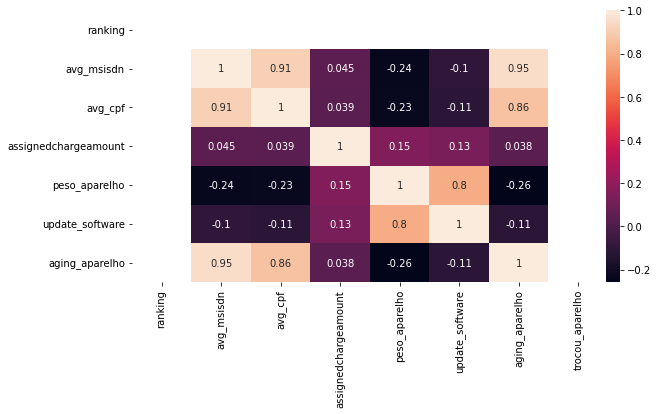

In [74]:
corr_ag = corr_aging_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_ag, xticklabels = corr.columns, yticklabels = corr_ag.columns, annot = True)

***
***
***
## Definição do Target aging_aparelho

In [75]:
# define target
y = base_to_pred_month['aging_aparelho']

In [76]:
# contagem de aging
from collections import Counter

c = Counter(y).most_common
c

<bound method Counter.most_common of Counter({12: 10332, 13: 9747, 14: 9358, 15: 9260, 16: 8799, 17: 8158, 18: 7719, 19: 7072, 27: 6853, 20: 6673, 28: 6651, 26: 6438, 21: 6245, 29: 5921, 25: 5587, 23: 5411, 22: 5374, 24: 5373, 30: 4875, 31: 4233, 32: 3900, 33: 3719, 35: 3708, 34: 3686, 36: 3685, 37: 3542, 38: 3508, 39: 3411, 40: 3294, 41: 2854, 42: 2220, 43: 1882, 44: 1858, 48: 1768, 46: 1732, 45: 1732, 47: 1730})>

In [77]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(20, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 45)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

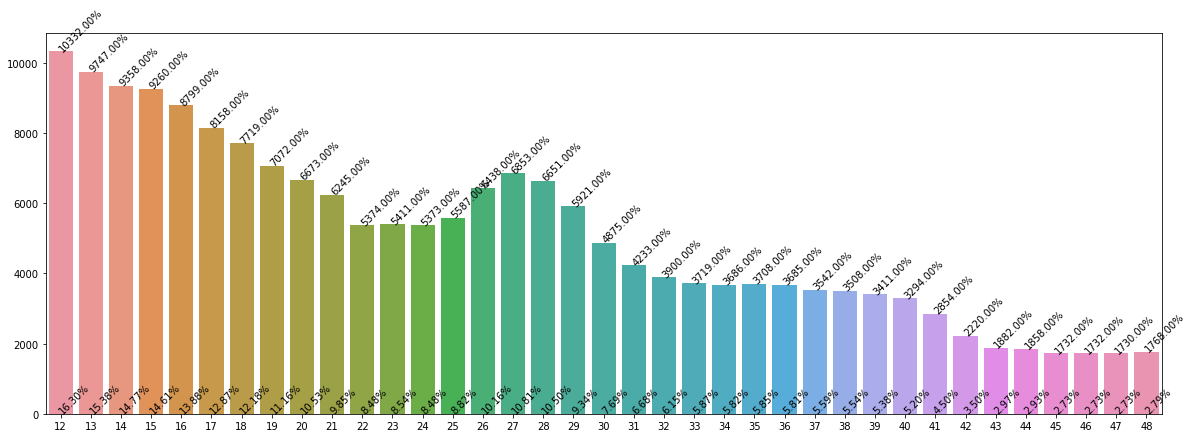

In [78]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(base_to_pred_month, 'aging_aparelho')

### Definicão das features

In [79]:
# define features
X = base_to_pred_month[['ranking', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software',
                        'assignedchargeamount']]

X

,ranking,avg_msisdn,avg_cpf,peso_aparelho,update_software,assignedchargeamount
0,1,12.0,12.0,2275,1,41.99
1,1,46.0,46.0,1865,1,247.67
2,1,43.0,43.0,1778,0,52.88
3,1,24.0,24.0,2215,1,0.00
4,1,23.0,23.0,1905,1,235.13
...,...,...,...,...,...,...
188303,1,14.5,14.5,1905,1,0.00
188304,1,10.5,10.5,2218,1,138.99
188305,1,19.0,19.0,1661,0,44.99
188306,1,18.0,18.0,1778,0,45.99


#### Variaveis Categoricas

In [80]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  0
[]


#### Variaveis Numéricas

In [81]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  6
['ranking', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software', 'assignedchargeamount']


***
## Modelagem

In [82]:
# Dividindo as features em dados de treino e teste - 70% para dados de treinamento e 30% para dados de teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                   ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('smote', SMOTE(random_state=42, n_jobs=-1)),   # equilibrar
                            ('model', XGBClassifier(random_state=2048, n_jobs=-1))
                          ])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Predictions
#preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds = pipeline.predict(X_val)

[16:46:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Save Model

In [83]:
# Use pickle to save model for next usage.
filename2 = 'model_aging_apple.pk'
with open('./'+filename2, 'wb') as file:
    pickle.dump(pipeline, file) 

In [84]:
train_yhat = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_yhat)
print('Training Acuracy:', train_acc)
val_acc = accuracy_score(y_val, preds)
print('Validation Acuracy:', val_acc)

Training Acuracy: 0.9809885931558935
Validation Acuracy: 0.9639526732799456


<Figure size 1440x432 with 0 Axes>

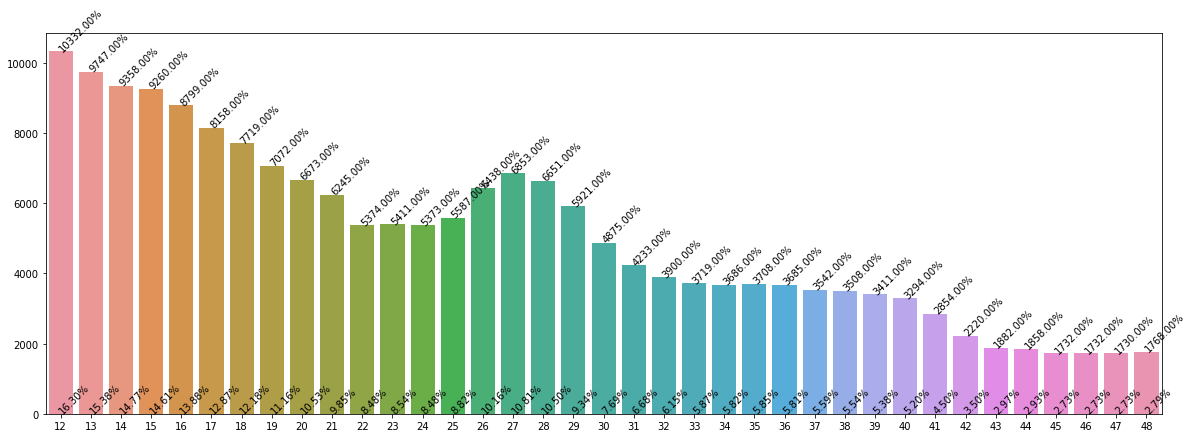

In [85]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(base_to_pred_month, 'aging_aparelho')

***
## Métricas

In [86]:
# # Multiply by -1 since sklearn calculates *negative* MAE
# scores = -1 * cross_val_score(pipeline, X_val, y_val,
#                               cv=5, n_jobs=-1, verbose=2,
#                               scoring='f1')

# print("MAE scores:\n", scores)

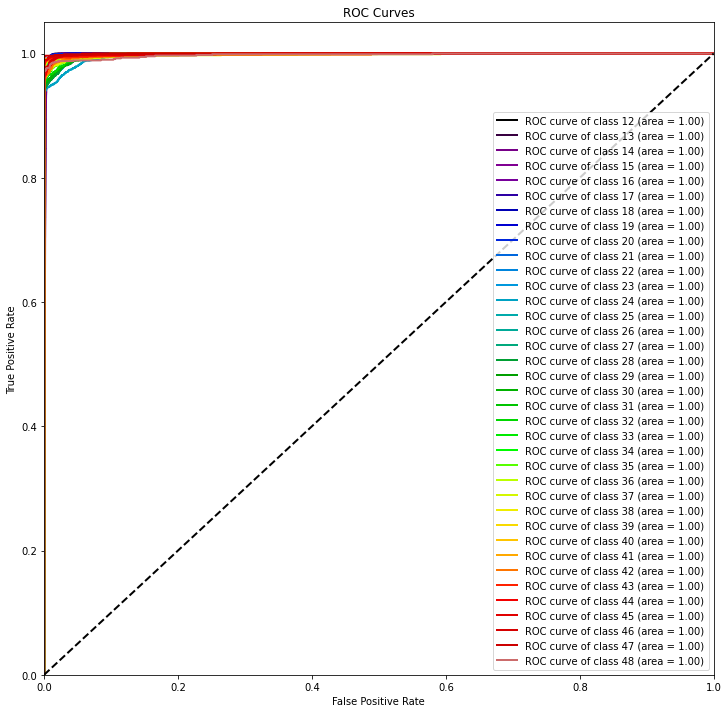

In [87]:
y_probas = pipeline.predict_proba(X_val)
plot_roc(y_val, y_probas, plot_micro = False, plot_macro = False, figsize = (12,12))
plt.show()

In [88]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.95      0.97      0.96      5148
          13       0.94      0.96      0.95      4797
          14       0.92      0.96      0.94      4677
          15       0.94      0.97      0.95      4643
          16       0.93      0.97      0.95      4372
          17       0.94      0.96      0.95      4142
          18       0.94      0.96      0.95      3834
          19       0.95      0.96      0.96      3482
          20       0.94      0.97      0.95      3345
          21       0.95      0.97      0.96      3178
          22       0.95      0.98      0.97      2693
          23       0.98      0.97      0.97      2657
          24       0.98      0.93      0.96      2693
          25       0.98      0.97      0.97      2826
          26       0.99      0.94      0.97      3218
          27       0.98      0.97      0.97      3410
          28       0.99      0.94      0.97      3361
          29       0.98    

In [89]:
preds.shape

(94154,)

In [90]:
# cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
#                      index = sorted(Counter(y_val)),
#                      columns = sorted(Counter(preds)))
# cm_df

## Plot non-normalized confusion matrix

In [91]:
y.unique()

array([12, 46, 43, 24, 23, 37, 16, 29, 39, 17, 31, 19, 26, 48, 38, 34, 15,
       27, 35, 32, 33, 22, 25, 20, 41, 44, 13, 30, 28, 45, 18, 21, 14, 47,
       40, 42, 36])

***
## Mesclando resultados com tabela

### Com a base de validação

In [93]:
X_val['aging_aparelho'] = y_val
# X_val

In [94]:
X_val['previsto'] = preds
# X_val

In [95]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [96]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [97]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [98]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,ranking,avg_msisdn,avg_cpf,peso_aparelho,update_software,assignedchargeamount,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
34463,1,34.0,34.0,1905,1,78.42,34,34,6.973558e+10,2019-04-16,2022-03-15,2022-02
151290,1,27.0,27.0,2218,1,489.99,27,27,5.651469e+10,2020-03-05,2022-06-15,2022-06
38043,1,21.0,21.0,1661,0,86.99,21,21,1.773778e+10,2020-08-06,2022-05-19,2022-05
68271,1,18.0,18.0,1660,0,56.99,18,18,1.732045e+10,2020-08-19,2022-03-12,2022-02
128184,1,17.0,17.0,1457,0,138.99,17,17,8.731675e+10,2020-12-29,2022-06-11,2022-05
...,...,...,...,...,...,...,...,...,...,...,...,...
44026,1,35.0,35.0,1905,1,56.49,35,35,8.025056e+10,2019-02-22,2022-02-14,2022-01
99455,1,28.0,28.0,1897,1,57.40,28,28,1.993142e+09,2019-12-23,2022-05-02,2022-04
99708,1,18.0,18.0,2105,1,63.93,18,18,7.458013e+10,2020-08-22,2022-03-10,2022-02
182700,1,21.0,21.0,1784,0,40.19,21,21,3.131443e+09,2020-06-12,2022-04-01,2022-03


<Figure size 1440x432 with 0 Axes>

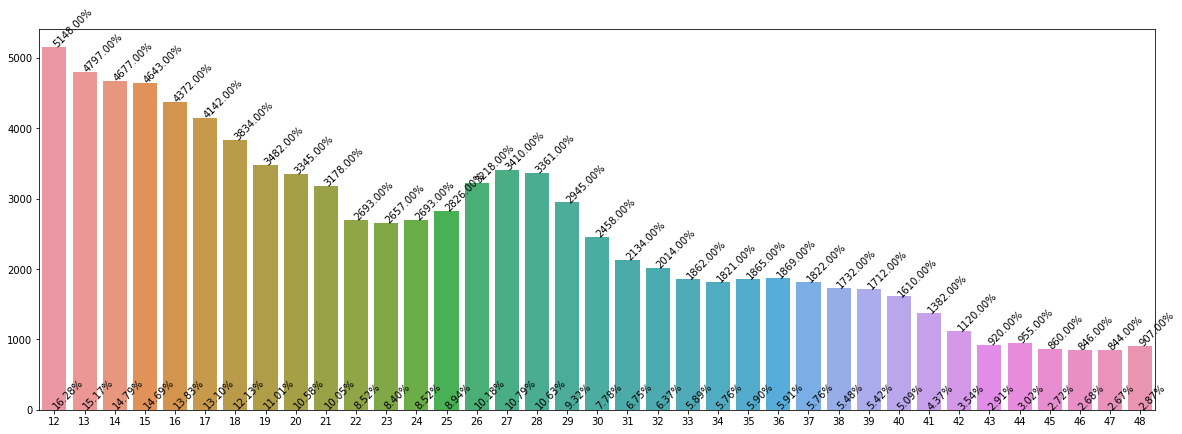

In [99]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(X_val, 'aging_aparelho')

<Figure size 1440x432 with 0 Axes>

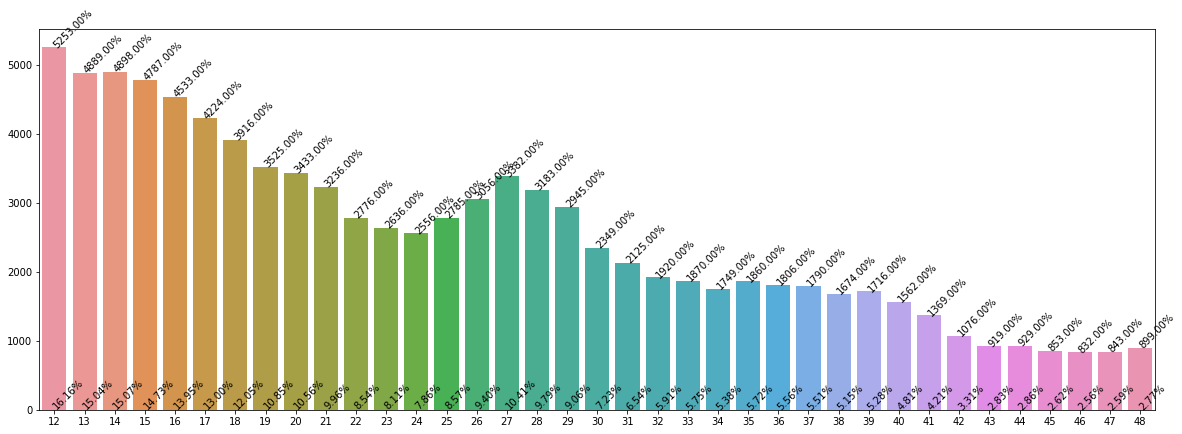

In [100]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq_mes(X_val, 'previsto')

***
***
***
### Teste com outra base

In [101]:
dados_val_mes = dados_val[dados_val['trocou_aparelho'] == 1].reset_index(drop=True)

X_teste_mes = dados_val_mes.drop(['trocou_aparelho', 'aging_aparelho'], axis=1)

y_teste_mes = dados_val_mes['aging_aparelho']

In [102]:
preds_val_mes = pipeline.predict(X_teste_mes)
preds_val_mes

array([12, 12, 14, ..., 18, 16, 14])

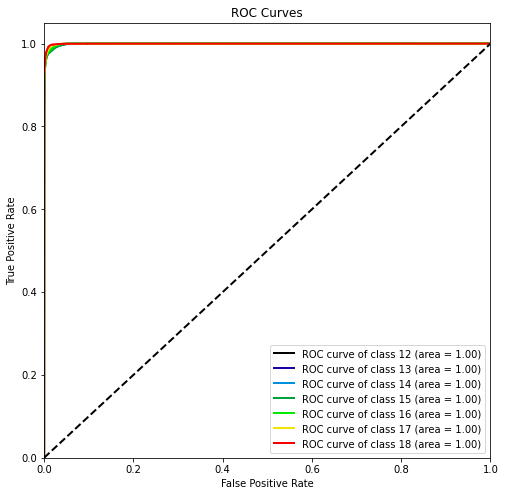

In [103]:
y_probas = pipeline.predict_proba(X_teste_mes)
plot_roc(y_teste_mes, y_probas, plot_micro = False, plot_macro = False, figsize = (8, 8))
plt.show()

In [104]:
print(classification_report(y_teste_mes, preds_val_mes))

              precision    recall  f1-score   support

          12       0.98      0.97      0.97     16708
          13       0.98      0.96      0.97     15514
          14       0.97      0.97      0.97     14847
          15       0.97      0.97      0.97     14801
          16       0.97      0.97      0.97     13922
          17       0.97      0.97      0.97     12923
          18       0.98      0.97      0.97     12227
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          24       0.00      0.00      0.00         0
          26       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         0
          31       0.00    

In [105]:
dados_val_mes['dt_ano_stts'].unique()

array([2020, 2019, 2017, 2015, 2016, 2013, 2014, 2012, 2021, 2011, 2010])

In [107]:
train_yhat = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_yhat)
print('Training Acuracy:', train_acc)
val_acc = accuracy_score(y_val, preds)
print('Validation Acuracy:', val_acc)
teste_acc = accuracy_score(y_teste, preds_val)
print('Test Acuracy:', teste_acc)

Training Acuracy: 0.9809885931558935
Validation Acuracy: 0.9639526732799456
Test Acuracy: 0.9999989175743708


In [128]:
# X_val.to_excel(r'ta_apple.xlsx')